In [ ]:
'''using google colab to train'''
# from google.colab import drive

# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/')
# !pwd

# '''/content/drive/MyDrive/Colab Notebooks/disk-measurement-dataset-2.npz'''

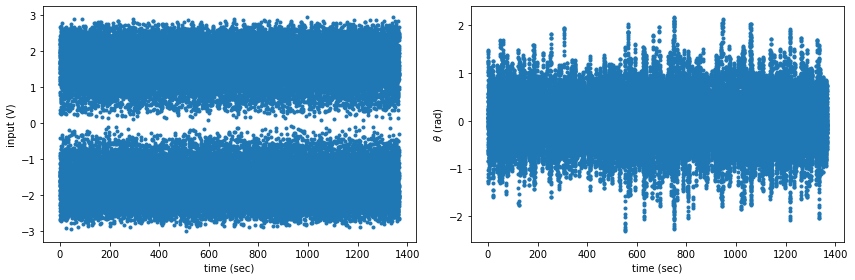

In [14]:
import numpy as np
from matplotlib import pyplot as plt

out = np.load('./disk-measurement-dataset-2.npz') 
u = out['u'] #inputs
th = out['th'] #outputs
t = out['t'] #time vector

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t,u,'.')
plt.xlabel('time (sec)')
plt.ylabel('input (V)')
plt.subplot(1,2,2)
plt.plot(t,th,'.')
plt.xlabel('time (sec)')
plt.ylabel('$\\theta$ (rad)')
plt.tight_layout()
plt.show()

In [15]:
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split

'''Linear net with 2 hidden layer'''
class Linear(nn.Module):
    def __init__(self,in_,hidden_1,hidden_2):
        super(Linear, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_,hidden_1,bias=True).double(),
            nn.ReLU(True),
            nn.Linear(hidden_1,hidden_2,bias=True).double(),
            nn.ReLU(True),
            nn.Linear(hidden_2,1,bias=True).double()
        )

    def forward(self,x):
        u = self.layer(x)[:,0]
        return u
        
def train(model,optimizer,criterion,epochs,Xtrain,Ytrain,Xval,Yval):
    model.train()
    train_loss = []
    val_loss =[]
    for epoch in range(epochs):
        Ypred = model(Xtrain.cuda())
        loss_train = criterion(Ypred.cuda(),Ytrain.cuda())
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        train_loss.append(loss_train.item())

        with torch.no_grad():
            model.eval()
            Ypred = model(Xval.cuda())
            loss_val = criterion(Ypred.cuda(), Yval)
            val_loss.append(loss_val.item())

        # if epoch%200 == 1:
        #     print(f'epoch={epoch} Train_loss={loss_train.item()} Val_loss={loss_val.item()}')
    return train_loss, val_loss 

def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)

In [16]:
Xdata, Ydata = make_training_data(u,th,2,1)
Xtrain,Xval,Ytrain,Yval = train_test_split(Xdata,Ydata)
if torch.cuda.is_available():
    Xtrain,Xval,Ytrain,Yval = [torch.as_tensor(x).cuda() for x in [Xtrain, Xval, Ytrain, Yval]]

model = Linear(Xtrain.shape[1],32,16)
model = model.to(torch.device('cuda:0'))
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.MSELoss()
train_loss, val_loss = train(model, optimizer, criterion, 1000, Xtrain, Ytrain, Xval, Yval)

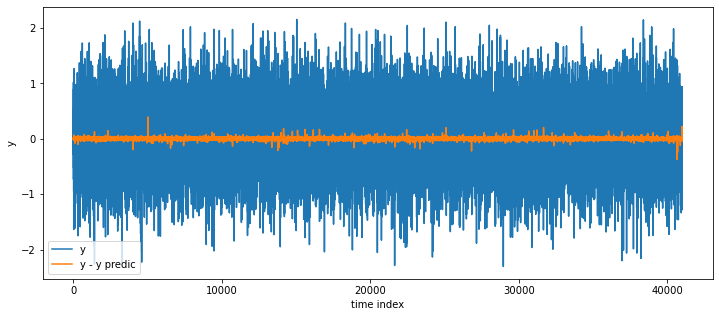

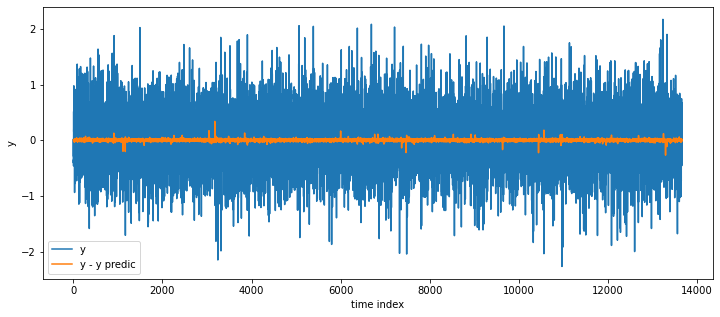

RMS prediction 0.015442267110754639
NRMS prediction 0.03130134209987814


In [17]:
with torch.no_grad():
    Ytrain_pred = model(Xtrain.cuda()) #b)
    res = Ytrain_pred - Ytrain #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Ytrain.cpu().numpy()) #b)
    plt.plot(res.cpu().numpy()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)

    Yval_pred = model(Xval.cuda()) #b)
    res = Yval_pred - Yval #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Yval.cpu().numpy()) #b)
    plt.plot(res.cpu().numpy()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)
    print('RMS prediction',np.mean((res.cpu().numpy()**2))**0.5) #b)
    print('NRMS prediction',np.mean((res.cpu().numpy()**2))**0.5/np.std(Yval.cpu().numpy())) #b)

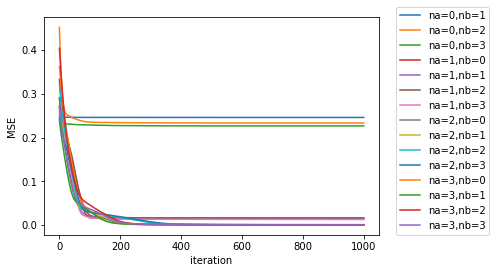

In [71]:
for na in [0,1,2,3]:
    for nb in [0,1,2,3]:
        if na + nb == 0:
            continue
        Xdata, Ydata = make_training_data(u,th,na,nb)
        Xtrain,Xval,Ytrain,Yval = train_test_split(Xdata,Ydata)
        
        if torch.cuda.is_available():
            Xtrain,Xval,Ytrain,Yval = [torch.as_tensor(x).cuda() for x in [Xtrain, Xval, Ytrain, Yval]]
            #print(Xtrain.shape)

        model = Linear(Xtrain.shape[1],32,16)
        model = model.to(torch.device('cuda:0'))
        learning_rate = 1e-3
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
        criterion = nn.MSELoss()

        train_loss, val_loss = train(model, optimizer, criterion, 1000, Xtrain, Ytrain, Xval, Yval)

        #plt.plot(train_loss)
        plt.plot(val_loss,label=f'na={na},nb={nb}')
        plt.xlabel('iteration')
        plt.ylabel('MSE')
        plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

In [18]:
'''na = 2, nb = 0'''
'''GP kernel: RBF(function) and White(noise)'''
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

Xdata, Ydata = make_training_data(u,th,2,0)
Xtrain,Xval,Ytrain,Yval = train_test_split(Xdata,Ydata)
Xtrain_sample,Xval_sample,Ytrain_sample,Yval_sample = Xtrain[:5000,:],Xval[:1000,:],Ytrain[:5000],Yval[:1000]        

ker = RBF(0.1) + WhiteKernel(0.01)
reg = GaussianProcessRegressor(ker,n_restarts_optimizer=10)
reg.fit(Xtrain_sample,Ytrain_sample)
Yval_p, Yval_p_std = reg.predict(Xval_sample,return_std=True)

RMS prediction 0.02617529777448516
NRMS prediction 0.05436453774853542


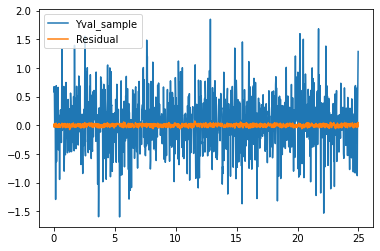

In [19]:
res = Yval_p-Yval_sample
plt.plot(t[:1000],Yval_sample,label='Yval_sample')
plt.plot(t[:1000],res,label='Residual')
plt.legend()
print('RMS prediction',np.mean((res**2))**0.5) #b)
print('NRMS prediction',np.mean((res**2))**0.5/np.std(Yval_sample)) #b)